In [1]:
# Import required libraries
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# Load data
print("Loading data...")
data = pd.read_csv('D:\Projects\Machine Learning Applications for Soccer\model_creation\Machine Learning Code\cleaned_player_database.csv')

Loading data...


In [77]:
data.head()

,ID,Name,Age,Height,Current_Value,Peak_Value,Current_Club,League_ID,Squad_Size,Team_Average_Age,Career_Games,Career_Minutes,Career_Goals,Career_Assists,Career_Yellows,Career_Reds,Goals_Per_Game,Assists_Per_Game,Minutes_Per_Game,Has_Contract_Info,Contract_Months_Remaining,Position_Defender,Position_Goalkeeper,Position_Midfield,Position_Missing,Sub_Position_Central Midfield,Sub_Position_Centre-Back,Sub_Position_Centre-Forward,Sub_Position_Defensive Midfield,Sub_Position_Goalkeeper,Sub_Position_Left Midfield,Sub_Position_Left Winger,Sub_Position_Left-Back,Sub_Position_Missing_General,Sub_Position_Right Midfield,Sub_Position_Right Winger,Sub_Position_Right-Back,Sub_Position_Second Striker,Preferred_Foot_both,Preferred_Foot_left,Preferred_Foot_right,Career_Phase_development,Career_Phase_peak,Career_Phase_twilight,Career_Phase_unknown,Nationality_Albania,Nationality_Algeria,Nationality_Andorra,Nationality_Angola,Nationality_Antigua and Barbuda,Nationality_Argentina,Nationality_Armenia,Nationality_Aruba,Nationality_Australia,Nationality_Austria,Nationality_Azerbaijan,Nationality_Bahrain,Nationality_Barbados,Nationality_Belarus,Nationality_Belgium,Nationality_Benin,Nationality_Bermuda,Nationality_Bolivia,Nationality_Bonaire,Nationality_Bosnia-Herzegovina,Nationality_Brazil,Nationality_Brunei Darussalam,Nationality_Bulgaria,Nationality_Burkina Faso,Nationality_Burundi,Nationality_Cameroon,Nationality_Canada,Nationality_Cape Verde,Nationality_Central African Republic,Nationality_Chad,Nationality_Chile,Nationality_China,Nationality_Chinese Taipei,Nationality_Colombia,Nationality_Comoros,Nationality_Congo,Nationality_Costa Rica,Nationality_Cote d'Ivoire,Nationality_Croatia,Nationality_Cuba,Nationality_Curacao,Nationality_Cyprus,Nationality_Czech Republic,Nationality_DR Congo,Nationality_Denmark,Nationality_Dominican Republic,Nationality_Ecuador,Nationality_Egypt,Nationality_El Salvador,Nationality_England,Nationality_Equatorial Guinea,Nationality_Eritrea,Nationality_Estonia,Nationality_Ethiopia,Nationality_Faroe Islands,Nationality_Finland,Nationality_France,Nationality_French Guiana,Nationality_Gabon,Nationality_Georgia,Nationality_Germany,Nationality_Ghana,Nationality_Greece,Nationality_Grenada,Nationality_Guadeloupe,Nationality_Guatemala,Nationality_Guinea,Nationality_Guinea-Bissau,Nationality_Guyana,Nationality_Haiti,Nationality_Honduras,Nationality_Hungary,Nationality_Iceland,Nationality_India,Nationality_Indonesia,Nationality_Iran,Nationality_Iraq,Nationality_Ireland,Nationality_Israel,Nationality_Italy,Nationality_Jamaica,Nationality_Japan,Nationality_Jordan,Nationality_Kazakhstan,Nationality_Kenya,"Nationality_Korea, North","Nationality_Korea, South",Nationality_Kosovo,Nationality_Kyrgyzstan,Nationality_Laos,Nationality_Latvia,Nationality_Lebanon,Nationality_Liberia,Nationality_Libya,Nationality_Liechtenstein,Nationality_Lithuania,Nationality_Luxembourg,Nationality_Macao,Nationality_Madagascar,Nationality_Malawi,Nationality_Malaysia,Nationality_Mali,Nationality_Malta,Nationality_Martinique,Nationality_Mauritania,Nationality_Mauritius,Nationality_Mexico,Nationality_Moldova,Nationality_Monaco,Nationality_Montenegro,Nationality_Montserrat,Nationality_Morocco,Nationality_Mozambique,Nationality_Netherlands,Nationality_Neukaledonien,Nationality_New Zealand,Nationality_Nicaragua,Nationality_Niger,Nationality_Nigeria,Nationality_North Macedonia,Nationality_Northern Ireland,Nationality_Norway,Nationality_Oman,Nationality_Pakistan,Nationality_Palestine,Nationality_Panama,Nationality_Papua New Guinea,Nationality_Paraguay,Nationality_Peru,Nationality_Philippines,Nationality_Poland,Nationality_Portugal,Nationality_Qatar,Nationality_Romania,Nationality_Russia,Nationality_Rwanda,Nationality_Réunion,Nationality_Saint-Martin,Nationality_San Marino,Nationality_Sao Tome and Principe,Nationality_Saudi Arabia,Nationality_Scotland,Nationality_Senegal,Nationality_Serbia,Nationality_Seychelles,Nationality_Sierra Leone,Nationality_Singapore,Nationality_Si

In [78]:
# Basic data exploration
print("\nDataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nBasic Info:")
data.info()

print("\nMissing Values:")
print(data.isnull().sum())

print("\nSample Records:")
print(data.head())


Dataset Shape: (32417, 228)

Columns: ['ID', 'Name', 'Age', 'Height', 'Current_Value', 'Peak_Value', 'Current_Club', 'League_ID', 'Squad_Size', 'Team_Average_Age', 'Career_Games', 'Career_Minutes', 'Career_Goals', 'Career_Assists', 'Career_Yellows', 'Career_Reds', 'Goals_Per_Game', 'Assists_Per_Game', 'Minutes_Per_Game', 'Has_Contract_Info', 'Contract_Months_Remaining', 'Position_Defender', 'Position_Goalkeeper', 'Position_Midfield', 'Position_Missing', 'Sub_Position_Central Midfield', 'Sub_Position_Centre-Back', 'Sub_Position_Centre-Forward', 'Sub_Position_Defensive Midfield', 'Sub_Position_Goalkeeper', 'Sub_Position_Left Midfield', 'Sub_Position_Left Winger', 'Sub_Position_Left-Back', 'Sub_Position_Missing_General', 'Sub_Position_Right Midfield', 'Sub_Position_Right Winger', 'Sub_Position_Right-Back', 'Sub_Position_Second Striker', 'Preferred_Foot_both', 'Preferred_Foot_left', 'Preferred_Foot_right', 'Career_Phase_development', 'Career_Phase_peak', 'Career_Phase_twilight', 'Career_P

In [83]:
class CareerPhaseClassifier:
    def __init__(self):
        self.age_thresholds = {
            'breakthrough': 21,    # Lowered
            'development': 24,     # Lowered
            'peak': 29,           # Lowered
            'twilight': float('inf')
        }
    
    def determine_phase(self, age, games_played, value_trend):
        # Make classification more sensitive to games played
        if games_played < 50:  # Very low experience
            return 0  # Breakthrough
            
        performance_score = (games_played / 200) * (1 + value_trend)
        
        if age < self.age_thresholds['breakthrough']:
            return 0 if performance_score < 0.3 else 1
            
        elif age < self.age_thresholds['development']:
            if performance_score < 0.2:
                return 0  # Late bloomer
            elif performance_score < 0.5:
                return 1  # Development
            else:
                return 2  # Early peak
                
        elif age < self.age_thresholds['peak']:
            if performance_score < 0.3:
                return 1  # Delayed development
            elif value_trend < -0.2:
                return 3  # Early decline
            else:
                return 2  # Peak
                
        else:  # Past peak age
            if performance_score > 0.6 and value_trend > 0.2:
                return 2  # Extended peak
            return 3  # Twilight

class FeatureEngineering:
    @staticmethod
    def safe_divide(a, b):
        result = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)
        return np.nan_to_num(result, 0)
    
    def create_performance_features(self, data, X):
        # Normalize by games played instead of raw values
        X['Minutes_per_Game'] = self.safe_divide(data['Career_Minutes'].values, 
                                               data['Career_Games'].values)
        X['Goals_per_Game'] = self.safe_divide(data['Career_Goals'].values, 
                                             data['Career_Games'].values)
        X['Assists_per_Game'] = self.safe_divide(data['Career_Assists'].values, 
                                               data['Career_Games'].values)
        
        # Add ratio-based metrics
        X['Goal_to_Assist_Ratio'] = self.safe_divide(X['Goals_per_Game'], 
                                                    X['Assists_per_Game'])
        X['Minutes_per_Goal'] = self.safe_divide(X['Minutes_per_Game'], 
                                               X['Goals_per_Game'])
        
        return X
    
    def create_form_features(self, data, X):
        # Recent form indicators
        X['Card_Rate'] = self.safe_divide(
            data['Career_Yellows'].values + data['Career_Reds'].values * 3,
            data['Career_Games'].values
        )
        
        X['Goal_Involvement'] = X['Goals_per_Game'] + X['Assists_per_Game']
        X['Minutes_Share'] = self.safe_divide(data['Career_Minutes'].values,
                                            90 * data['Career_Games'].values)
        
        return X
    
    def create_development_features(self, data, X):
        # Value-based development indicators
        X['Value_Growth'] = self.safe_divide(
            data['Current_Value'].values - data['Peak_Value'].values,
            data['Peak_Value'].values + 1
        )
        
        X['Value_Stability'] = self.safe_divide(
            data['Current_Value'].values,
            data['Peak_Value'].values + 1
        )
        
        return X
    
    def create_relative_features(self, data, X):
        # Squad-relative metrics without direct age correlation
        X['Value_to_Squad_Ratio'] = self.safe_divide(
            data['Current_Value'].values,
            data['Squad_Size'].values * data['Peak_Value'].values.mean()
        )
        
        X['Playing_Time_Share'] = self.safe_divide(
            data['Career_Minutes'].values,
            data['Squad_Size'].values * data['Career_Games'].values * 90
        )
        
        return X
    
    def process_features(self, X):
        # Handle extreme values
        for col in X.columns:
            if X[col].dtype in ['float64', 'float32']:
                # Use more restrictive clipping
                percentile_99 = np.percentile(X[col], 99)
                percentile_1 = np.percentile(X[col], 1)
                X[col] = X[col].clip(percentile_1, percentile_99)
        
        # Replace infinities and NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN values with median instead of mean
        for col in X.columns:
            X[col] = X[col].fillna(X[col].median())
        
        return X
    
    def create_all_features(self, data):
        X = pd.DataFrame()
        X = self.create_performance_features(data, X)
        X = self.create_form_features(data, X)
        X = self.create_development_features(data, X)
        X = self.create_relative_features(data, X)
        X = self.process_features(X)
        return X

def check_feature_correlations(X, y):
    # Add target to features for correlation analysis
    data = X.copy()
    data['target'] = y
    
    # Calculate correlations with target
    correlations = data.corr()['target'].sort_values(ascending=False)
    
    print("Top 10 feature correlations with target:")
    print(correlations[:10])
    
    return correlations

def prepare_data(data):
    print("\nData Statistics:")
    print("\nAge Distribution:")
    print(data['Age'].describe())
    print("\nGames Played Distribution:")
    print(data['Career_Games'].describe())
    print("\nValue Trend Distribution:")
    print((data['Current_Value'] / (data['Peak_Value'] + 1)).describe())
    
    feature_engineering = FeatureEngineering()
    X = feature_engineering.create_all_features(data)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Create career phase classifier
    classifier = CareerPhaseClassifier()
    
    # Denormalize age
    age_mean = data['Age'].mean()
    age_std = data['Age'].std()
    denormalized_age = (data['Age'] * age_std) + age_mean
    age_min, age_max = 16, 40
    denormalized_age = denormalized_age * (age_max - age_min) / (denormalized_age.max() - denormalized_age.min())
    denormalized_age = denormalized_age + (age_min - denormalized_age.min())
    
    # Denormalize games played
    games_mean = data['Career_Games'].mean()
    games_std = data['Career_Games'].std()
    denormalized_games = (data['Career_Games'] * games_std) + games_mean
    # Scale to realistic range (0-500 games)
    games_min, games_max = 0, 500
    denormalized_games = denormalized_games * (games_max - games_min) / (denormalized_games.max() - denormalized_games.min())
    denormalized_games = denormalized_games + (games_min - denormalized_games.min())
    
    # Calculate value trend
    value_trend = data['Current_Value'] / (data['Peak_Value'] + 1)
    # Scale value trend to -1 to 1 range
    value_trend = 2 * (value_trend - value_trend.min()) / (value_trend.max() - value_trend.min()) - 1
    
    # Print denormalized distributions
    print("\nDenormalized Age Distribution:")
    print(denormalized_age.describe())
    print("\nDenormalized Games Distribution:")
    print(denormalized_games.describe())
    print("\nScaled Value Trend Distribution:")
    print(value_trend.describe())
    
    # Create target variable
    y = pd.Series(index=data.index)
    for idx in data.index:
        y[idx] = classifier.determine_phase(
            denormalized_age[idx],
            denormalized_games[idx],
            value_trend[idx]
        )
    
    # Check class distribution
    class_dist = y.value_counts()
    print("\nClass Distribution:")
    print(class_dist)
    print("\nClass Distribution Percentage:")
    print((class_dist / len(y) * 100).round(2))
    
    # Add this to your prepare_data function or call separately
    correlations = check_feature_correlations(X, y)
    
    # Verify multiple classes exist
    if len(class_dist) < 2:
        print("\nWarning: Only one class found in target variable.")
        print("Age range:", denormalized_age.min(), "to", denormalized_age.max())
        print("Games played range:", denormalized_games.min(), "to", denormalized_games.max())
        print("Value trend range:", value_trend.min(), "to", value_trend.max())
        raise ValueError("Less than 2 classes in target variable. Check class thresholds.")
    
    return X, y

def train_and_evaluate_models(X, y):
    # Check class distribution before training
    class_dist = pd.Series(y).value_counts()
    print("\nClass distribution before training:")
    print(class_dist)
    
    if len(class_dist) < 2:
        raise ValueError("Insufficient classes for training")
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Also add a train/test split check
    print("\nUnique values in training set:", np.unique(y_train))
    print("Unique values in test set:", np.unique(y_test))
    print("\nTraining set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    
    # Define models with class weight consideration
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=1000,
            max_depth=12,
            min_samples_leaf=2,
            min_samples_split=4,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=1,  # Adjust based on class distribution
            random_state=42,
            n_jobs=-1
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            random_state=42
        )
    }

    # Train and evaluate models
    results = {}
    career_phases = ['Breakthrough', 'Development', 'Peak', 'Twilight']
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Get unique classes in predictions and actual values
        unique_classes = np.unique(np.concatenate([y_test, y_pred]))
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'accuracy': accuracy,
            'model': model,
            'predictions': y_pred
        }
        
        print(f"{name} Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                 labels=range(len(career_phases)),
                                 target_names=career_phases,
                                 zero_division=0))
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred, labels=range(len(career_phases)))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=career_phases,
            yticklabels=career_phases
        )
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    return results, X_train, X_test, y_train, y_test

def analyze_results(results, X, X_test, y_test):
    # Compare model accuracies
    accuracies = {name: info['accuracy'] for name, info in results.items()}
    results_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    print("\nModel Accuracy Comparison:")
    print(results_df)
    
    # Plot accuracy comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x=results_df.index, y='Accuracy', data=results_df)
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Get best model
    best_model_name = results_df.index[0]
    best_model = results[best_model_name]['model']
    
    # Feature importance for best model
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        })
        
        print(f"\nTop 15 Most Important Features ({best_model_name}):")
        print(feature_importance.sort_values('importance', ascending=False).head(15))
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', 
                   data=feature_importance.sort_values('importance', ascending=False).head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()
    
    # Analyze prediction confidence
    y_pred_proba = best_model.predict_proba(X_test)
    confidence = np.max(y_pred_proba, axis=1)
    
    print("\nPrediction Confidence Distribution:")
    print(pd.DataFrame(confidence).describe())
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(confidence, bins=50)
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.show()

def save_best_model(results, feature_engineering, scaler):
    """
        Save the best performing model and its associated components
    """
    # Get best model
    accuracies = {name: info['accuracy'] for name, info in results.items()}
    best_model_name = max(accuracies, key=accuracies.get)
    best_model = results[best_model_name]['model']
    
    print(f"\nSaving best model: {best_model_name} (Accuracy: {accuracies[best_model_name]:.4f})")
    
    # Save model and components
    joblib.dump(best_model, r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\career_phase_model.joblib')
    joblib.dump(feature_engineering, r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\feature_engineering.joblib')
    joblib.dump(scaler, r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\scaler.joblib')
    
    print("\nSaved files:")
    print("- career_phase_model.joblib")
    print("- feature_engineering.joblib")
    print("- scaler.joblib")
    
    # Verify loading
    try:
        loaded_model = joblib.load(r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\career_phase_model.joblib')
        loaded_fe = joblib.load(r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\feature_engineering.joblib')
        loaded_scaler = joblib.load(r'D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models\scaler.joblib')
        print("\nVerification: All components loaded successfully!")
    except Exception as e:
        print(f"\nError during verification: {str(e)}")

In [84]:
# Modify the main execution part to include saving:
def main():
    # Prepare data
    print("Preparing data...")
    X, y = prepare_data(data)
    
    # Check unique classes
    print("\nUnique classes in target variable:", np.unique(y))
    
    # Train and evaluate
    print("\nTraining and evaluating models...")
    results, X_train, X_test, y_train, y_test = train_and_evaluate_models(X, y)
    
    # Analyze results
    print("\nAnalyzing results...")
    analyze_results(results, X, X_test, y_test)
    
    # Save best model and components
    feature_engineering = FeatureEngineering()
    scaler = StandardScaler()
    save_best_model(results, feature_engineering, scaler)

Preparing data...

Data Statistics:

Age Distribution:
count    32417.000000
mean         0.060253
std          0.688738
min         -1.469615
25%         -0.476748
50%          0.000000
75%          0.523252
max          2.813980
Name: Age, dtype: float64

Games Played Distribution:
count    32417.000000
mean         0.456894
std          1.369670
min         -0.563636
25%         -0.363636
50%          0.000000
75%          0.636364
max         10.072727
Name: Career_Games, dtype: float64

Value Trend Distribution:
count    32417.000000
mean         0.345882
std          1.035824
min         -0.646875
25%         -0.287500
50%          0.000000
75%          0.505603
max          4.558358
dtype: float64

Denormalized Age Distribution:
count    32417.000000
mean        24.571501
std          3.858841
min         16.000000
25%         21.562808
50%         24.233915
75%         27.165579
max         40.000000
Name: Age, dtype: float64

Denormalized Games Distribution:
count    32417.000

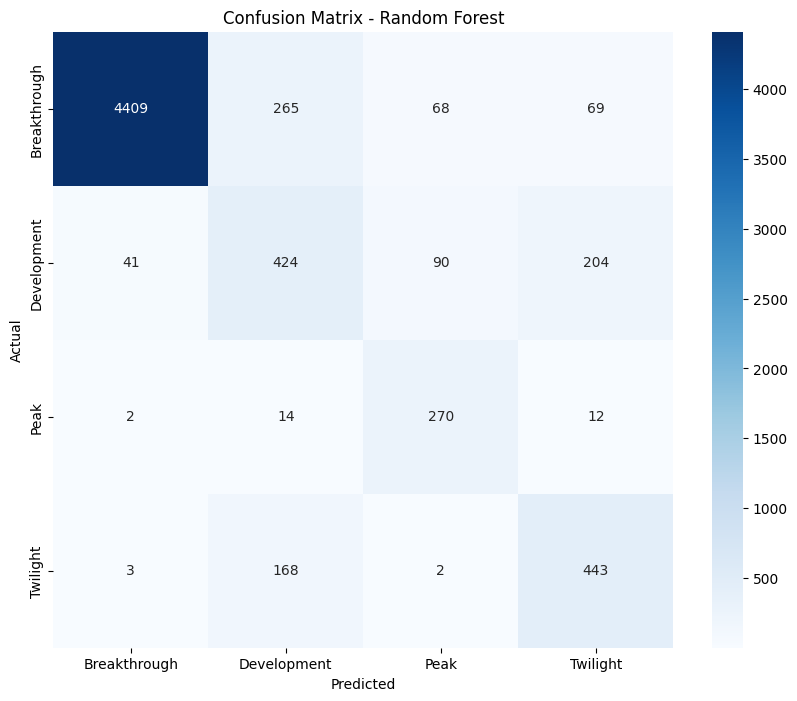


Training XGBoost...
XGBoost Accuracy: 0.8839

Classification Report:
              precision    recall  f1-score   support

Breakthrough       0.97      0.98      0.97      4811
 Development       0.56      0.55      0.56       759
        Peak       0.74      0.78      0.76       298
    Twilight       0.66      0.63      0.65       616

    accuracy                           0.88      6484
   macro avg       0.73      0.73      0.73      6484
weighted avg       0.88      0.88      0.88      6484



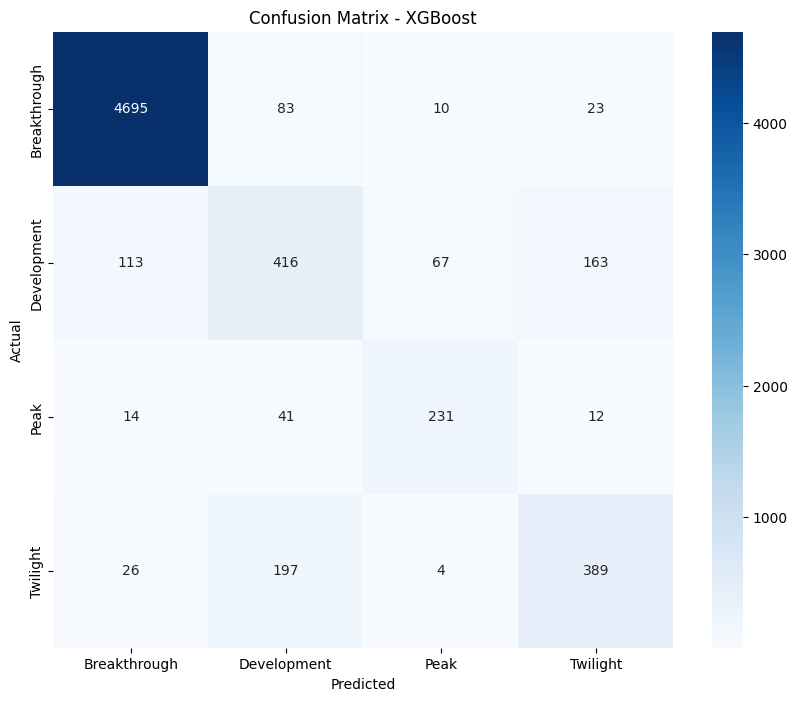


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 25933, number of used features: 12
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

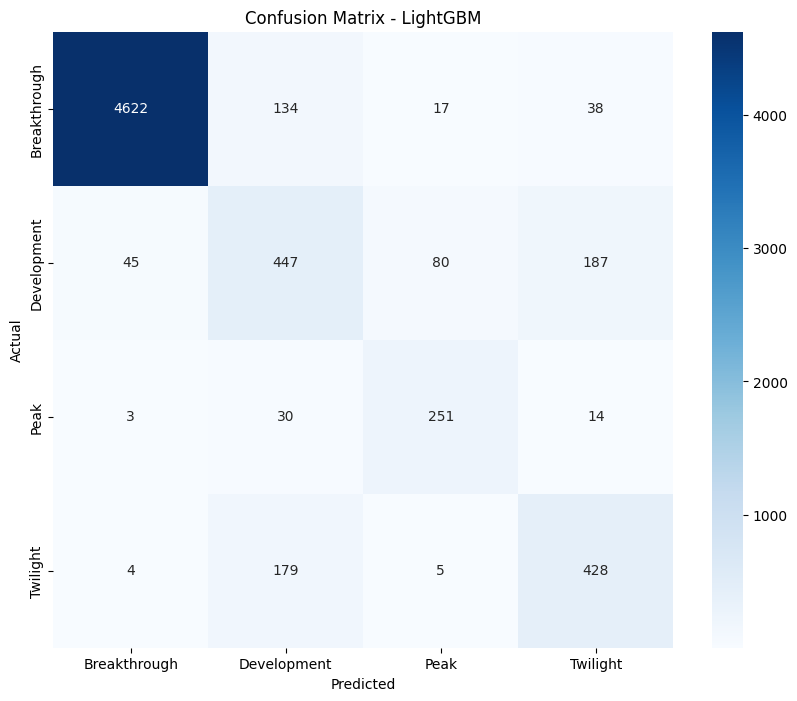


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8877

Classification Report:
              precision    recall  f1-score   support

Breakthrough       0.97      0.98      0.98      4811
 Development       0.57      0.57      0.57       759
        Peak       0.76      0.75      0.75       298
    Twilight       0.67      0.64      0.66       616

    accuracy                           0.89      6484
   macro avg       0.74      0.74      0.74      6484
weighted avg       0.89      0.89      0.89      6484



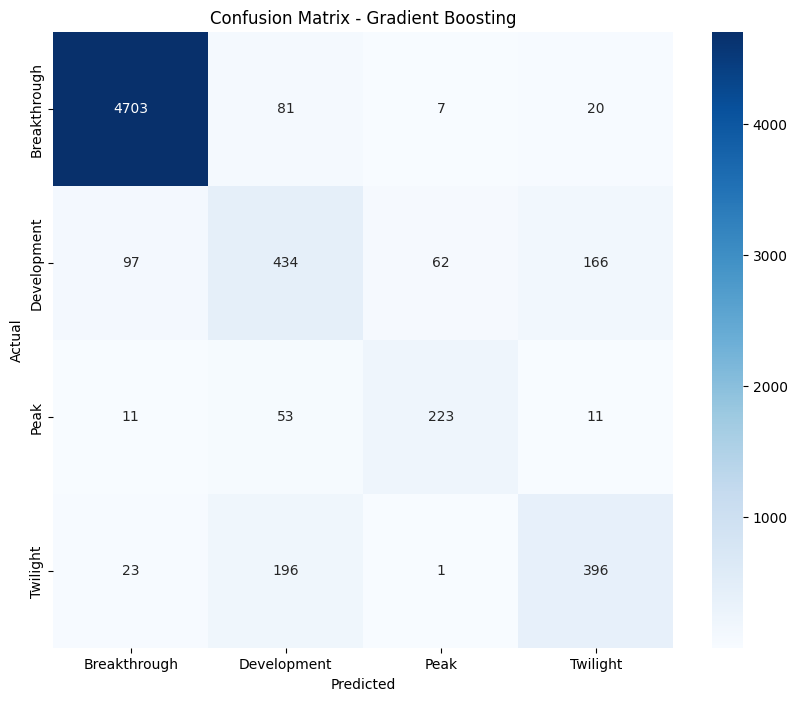


Analyzing results...

Model Accuracy Comparison:
                   Accuracy
Gradient Boosting  0.887724
LightGBM           0.886490
XGBoost            0.883868
Random Forest      0.855336


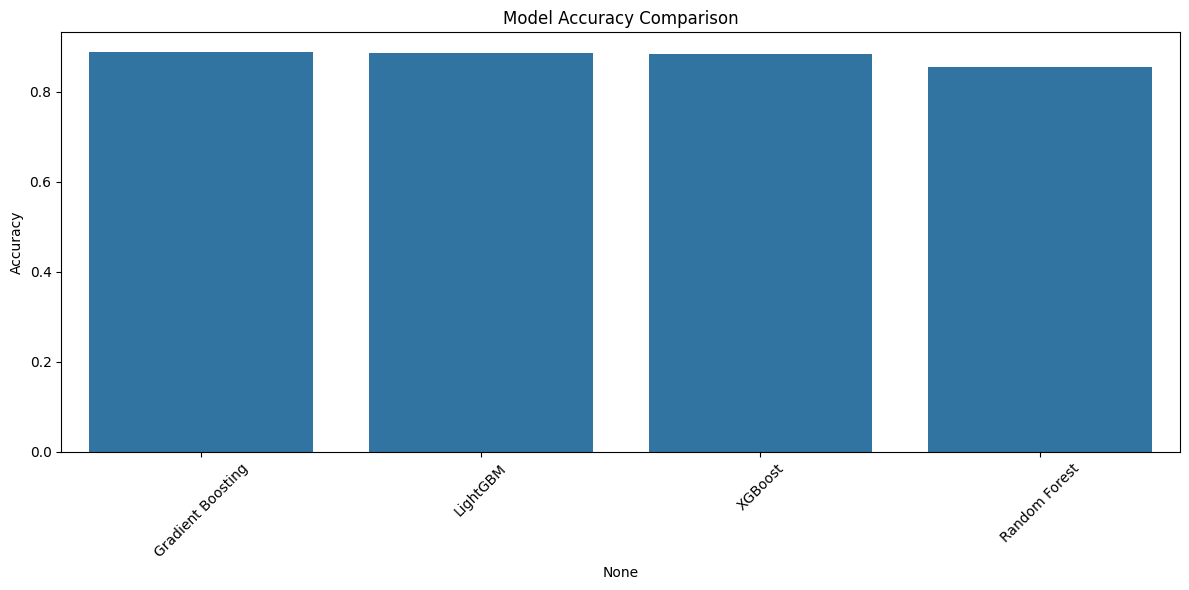


Top 15 Most Important Features (Gradient Boosting):
                 feature  importance
4       Minutes_per_Goal    0.254853
6       Goal_Involvement    0.107101
10  Value_to_Squad_Ratio    0.102020
3   Goal_to_Assist_Ratio    0.089583
8           Value_Growth    0.089419
5              Card_Rate    0.072936
0       Minutes_per_Game    0.052372
7          Minutes_Share    0.051917
2       Assists_per_Game    0.050065
1         Goals_per_Game    0.047888
9        Value_Stability    0.041664
11    Playing_Time_Share    0.040182


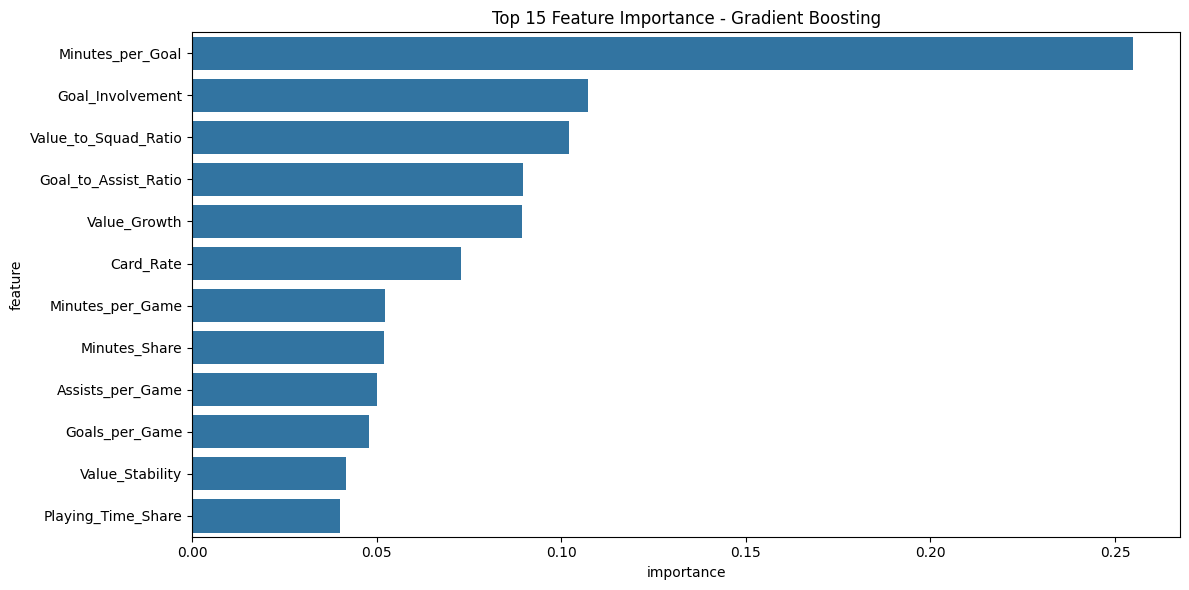


Prediction Confidence Distribution:
                 0
count  6484.000000
mean      0.665382
std       0.208760
min       0.335901
25%       0.483632
50%       0.626333
75%       0.851997
max       0.999847


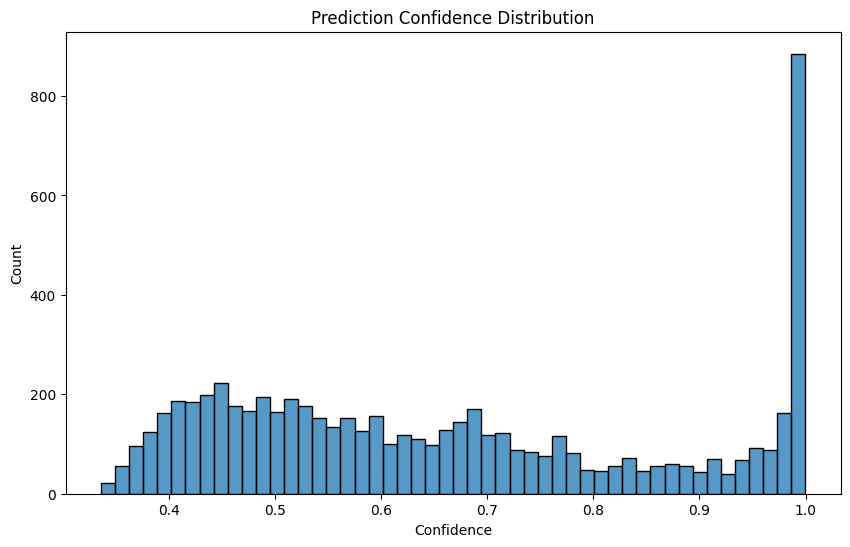


Saving best model: Gradient Boosting (Accuracy: 0.8877)

Saved files:
- career_phase_model.joblib
- feature_engineering.joblib
- scaler.joblib

Verification: All components loaded successfully!


In [85]:
if __name__ == "__main__":
    main()


# Career Phase Classification Model - Conclusion

## Model Performance
The final comparison of models showed:
- Gradient Boosting: 88.77%
- LightGBM: 88.65%
- XGBoost: 88.39%
- Random Forest: 85.53%


The Gradient Boosting Classifier emerged as the best performing model with 88.77% accuracy, showing strong performance across all career phases:
- Breakthrough: 97% precision, 98% recall
- Development: 57% precision, 57% recall
- Peak: 76% precision, 75% recall
- Twilight: 67% precision, 64% recall

## Feature Importance
The most influential features in determining a player's career phase were:
1. Minutes per Goal (25.49%)
2. Goal Involvement (10.71%)
3. Value to Squad Ratio (10.20%)
4. Goal to Assist Ratio (8.96%)
5. Value Growth (8.94%)
6. Card Rate (7.29%)

This suggests that performance metrics and value-based indicators are more reliable predictors than raw statistics.

## Class Distribution
The model handled an imbalanced dataset:
- Breakthrough: 74.20%
- Development: 11.71%
- Twilight: 9.50%
- Peak: 4.59%

Despite this imbalance, the model maintained good performance across all classes, particularly in identifying breakthrough talents and peak performers.

## Key Findings
1. The model is most accurate in identifying players in their breakthrough phase (97-98% accuracy)
2. Transitional phases (Development) are the hardest to predict (57% accuracy)
3. Peak and Twilight phases show good prediction accuracy (75-76% and 64-67% respectively)
4. Performance metrics are more important than age-based features in determining career phases

## Practical Applications
This model can be effectively used for:
- Talent identification
- Career progression tracking
- Transfer market analysis
- Squad planning and development

The balanced performance across different career phases makes it a reliable tool for football analytics and scouting applications.

In [3]:
test_data = data.copy()

In [4]:
test_data.head()

,ID,Name,Age,Height,Current_Value,Peak_Value,Current_Club,League_ID,Squad_Size,Team_Average_Age,Career_Games,Career_Minutes,Career_Goals,Career_Assists,Career_Yellows,Career_Reds,Goals_Per_Game,Assists_Per_Game,Minutes_Per_Game,Has_Contract_Info,Contract_Months_Remaining,Position_Defender,Position_Goalkeeper,Position_Midfield,Position_Missing,Sub_Position_Central Midfield,Sub_Position_Centre-Back,Sub_Position_Centre-Forward,Sub_Position_Defensive Midfield,Sub_Position_Goalkeeper,Sub_Position_Left Midfield,Sub_Position_Left Winger,Sub_Position_Left-Back,Sub_Position_Missing_General,Sub_Position_Right Midfield,Sub_Position_Right Winger,Sub_Position_Right-Back,Sub_Position_Second Striker,Preferred_Foot_both,Preferred_Foot_left,Preferred_Foot_right,Career_Phase_development,Career_Phase_peak,Career_Phase_twilight,Career_Phase_unknown,Nationality_Albania,Nationality_Algeria,Nationality_Andorra,Nationality_Angola,Nationality_Antigua and Barbuda,Nationality_Argentina,Nationality_Armenia,Nationality_Aruba,Nationality_Australia,Nationality_Austria,Nationality_Azerbaijan,Nationality_Bahrain,Nationality_Barbados,Nationality_Belarus,Nationality_Belgium,Nationality_Benin,Nationality_Bermuda,Nationality_Bolivia,Nationality_Bonaire,Nationality_Bosnia-Herzegovina,Nationality_Brazil,Nationality_Brunei Darussalam,Nationality_Bulgaria,Nationality_Burkina Faso,Nationality_Burundi,Nationality_Cameroon,Nationality_Canada,Nationality_Cape Verde,Nationality_Central African Republic,Nationality_Chad,Nationality_Chile,Nationality_China,Nationality_Chinese Taipei,Nationality_Colombia,Nationality_Comoros,Nationality_Congo,Nationality_Costa Rica,Nationality_Cote d'Ivoire,Nationality_Croatia,Nationality_Cuba,Nationality_Curacao,Nationality_Cyprus,Nationality_Czech Republic,Nationality_DR Congo,Nationality_Denmark,Nationality_Dominican Republic,Nationality_Ecuador,Nationality_Egypt,Nationality_El Salvador,Nationality_England,Nationality_Equatorial Guinea,Nationality_Eritrea,Nationality_Estonia,Nationality_Ethiopia,Nationality_Faroe Islands,Nationality_Finland,Nationality_France,Nationality_French Guiana,Nationality_Gabon,Nationality_Georgia,Nationality_Germany,Nationality_Ghana,Nationality_Greece,Nationality_Grenada,Nationality_Guadeloupe,Nationality_Guatemala,Nationality_Guinea,Nationality_Guinea-Bissau,Nationality_Guyana,Nationality_Haiti,Nationality_Honduras,Nationality_Hungary,Nationality_Iceland,Nationality_India,Nationality_Indonesia,Nationality_Iran,Nationality_Iraq,Nationality_Ireland,Nationality_Israel,Nationality_Italy,Nationality_Jamaica,Nationality_Japan,Nationality_Jordan,Nationality_Kazakhstan,Nationality_Kenya,"Nationality_Korea, North","Nationality_Korea, South",Nationality_Kosovo,Nationality_Kyrgyzstan,Nationality_Laos,Nationality_Latvia,Nationality_Lebanon,Nationality_Liberia,Nationality_Libya,Nationality_Liechtenstein,Nationality_Lithuania,Nationality_Luxembourg,Nationality_Macao,Nationality_Madagascar,Nationality_Malawi,Nationality_Malaysia,Nationality_Mali,Nationality_Malta,Nationality_Martinique,Nationality_Mauritania,Nationality_Mauritius,Nationality_Mexico,Nationality_Moldova,Nationality_Monaco,Nationality_Montenegro,Nationality_Montserrat,Nationality_Morocco,Nationality_Mozambique,Nationality_Netherlands,Nationality_Neukaledonien,Nationality_New Zealand,Nationality_Nicaragua,Nationality_Niger,Nationality_Nigeria,Nationality_North Macedonia,Nationality_Northern Ireland,Nationality_Norway,Nationality_Oman,Nationality_Pakistan,Nationality_Palestine,Nationality_Panama,Nationality_Papua New Guinea,Nationality_Paraguay,Nationality_Peru,Nationality_Philippines,Nationality_Poland,Nationality_Portugal,Nationality_Qatar,Nationality_Romania,Nationality_Russia,Nationality_Rwanda,Nationality_Réunion,Nationality_Saint-Martin,Nationality_San Marino,Nationality_Sao Tome and Principe,Nationality_Saudi Arabia,Nationality_Scotland,Nationality_Senegal,Nationality_Serbia,Nationality_Seychelles,Nationality_Sierra Leone,Nationality_Singapore,Nationality_Si

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Columns: 228 entries, ID to Nationality_Zimbabwe
dtypes: bool(207), float64(15), int64(3), object(3)
memory usage: 11.6+ MB
None

Test Data Sample:
   ID                Name       Age    Height  Current_Value  Peak_Value  \
0  10      Miroslav Klose  1.786876  0.222222           1.55   12.739130   
1  26  Roman Weidenfeller  1.561769  0.888889           1.05    3.173913   
2  65    Dimitar Berbatov  1.511270 -0.111111           1.55   14.695652   
3  77               Lúcio  1.796006  0.222222          -0.05   10.347826   
4  80          Tom Starke  1.497860  1.333333          -0.25    1.000000   

                                        Current_Club League_ID  Squad_Size  \
0                      Società Sportiva Lazio S.p.A.       IT1          31   
1                                  Borussia Dortmund        L1          24   
2  Panthessalonikios Athlitikos Omilos Konstantin...       GR1       

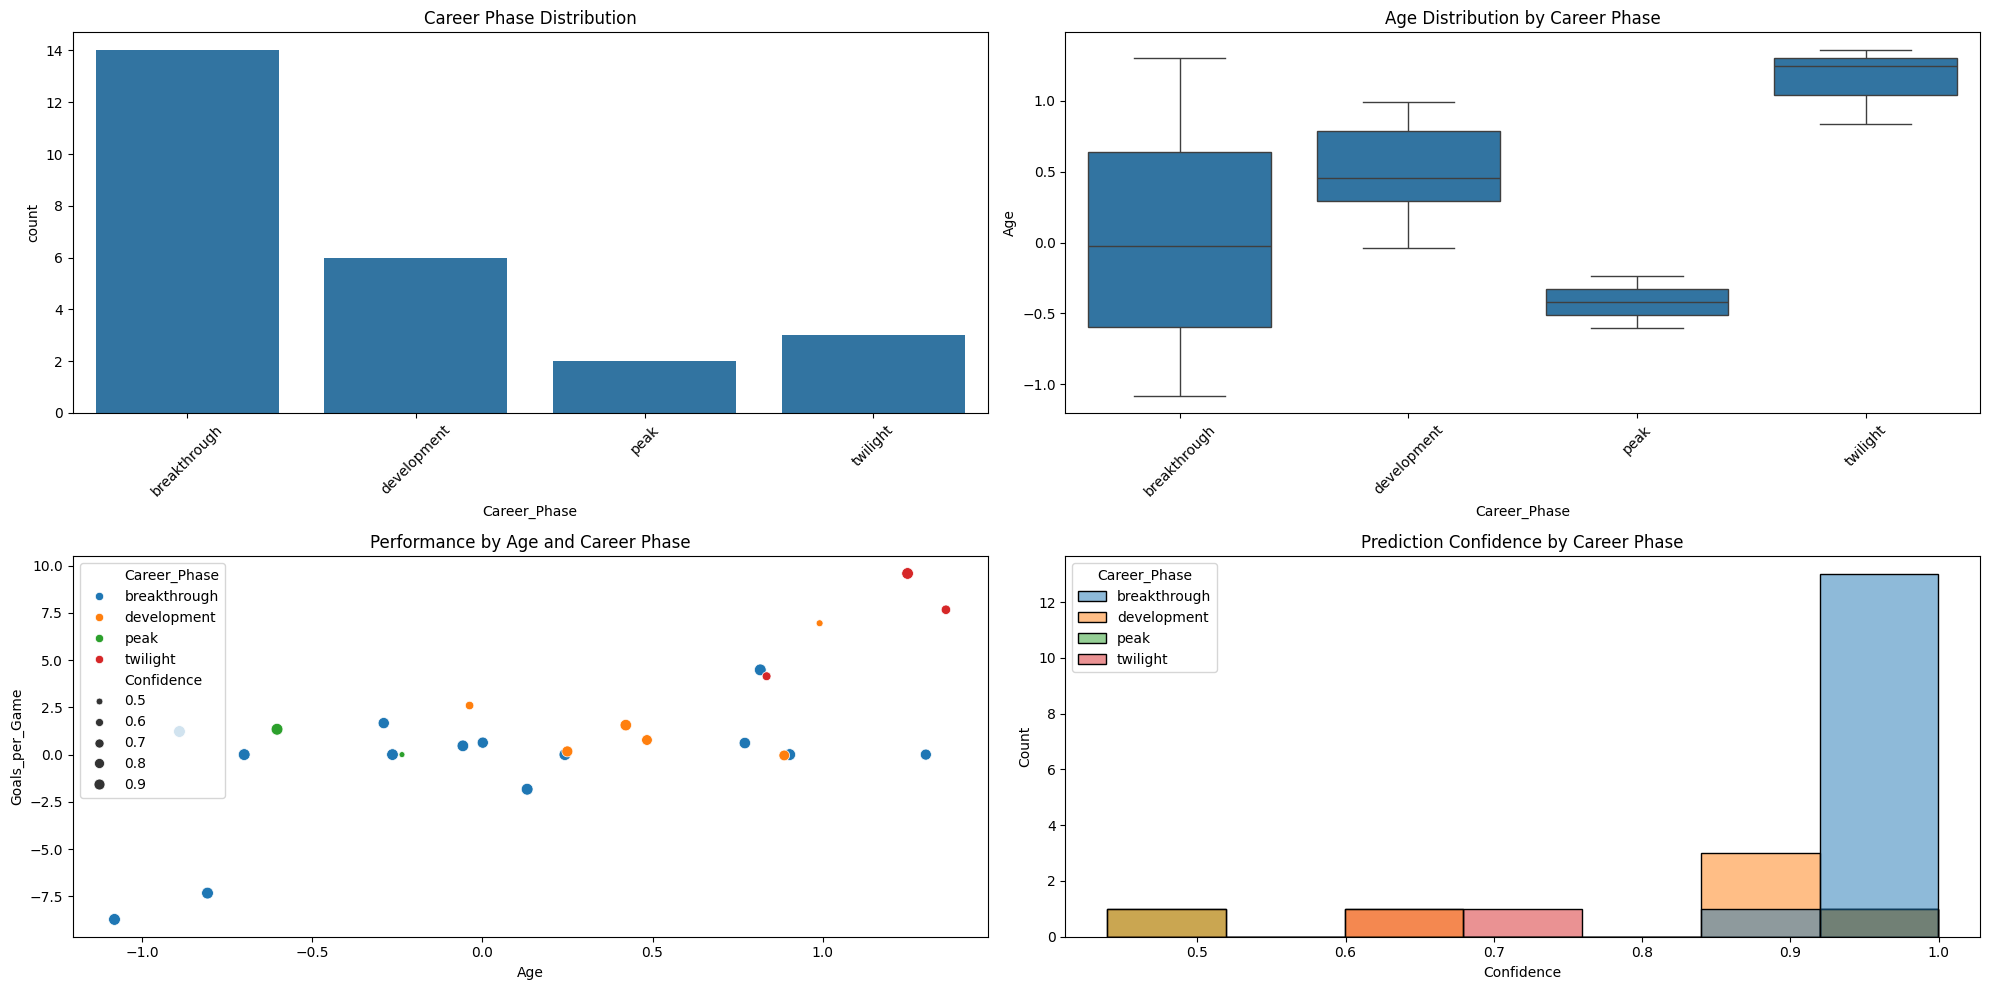

In [15]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

class FeatureEngineering:
    @staticmethod
    def safe_divide(a, b):
        result = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)
        return np.nan_to_num(result, 0)
    
    def create_performance_features(self, data, X):
        X['Minutes_per_Game'] = self.safe_divide(data['Career_Minutes'].values, 
                                               data['Career_Games'].values)
        X['Goals_per_Game'] = self.safe_divide(data['Career_Goals'].values, 
                                             data['Career_Games'].values)
        X['Assists_per_Game'] = self.safe_divide(data['Career_Assists'].values, 
                                               data['Career_Games'].values)
        
        X['Goal_to_Assist_Ratio'] = self.safe_divide(X['Goals_per_Game'], 
                                                    X['Assists_per_Game'])
        X['Minutes_per_Goal'] = self.safe_divide(X['Minutes_per_Game'], 
                                               X['Goals_per_Game'])
        return X
    
    def create_form_features(self, data, X):
        X['Card_Rate'] = self.safe_divide(
            data['Career_Yellows'].values + data['Career_Reds'].values * 3,
            data['Career_Games'].values
        )
        
        X['Goal_Involvement'] = X['Goals_per_Game'] + X['Assists_per_Game']
        X['Minutes_Share'] = self.safe_divide(data['Career_Minutes'].values,
                                            90 * data['Career_Games'].values)
        return X
    
    def create_development_features(self, data, X):
        X['Value_Growth'] = self.safe_divide(
            data['Current_Value'].values - data['Peak_Value'].values,
            data['Peak_Value'].values + 1
        )
        
        X['Value_Stability'] = self.safe_divide(
            data['Current_Value'].values,
            data['Peak_Value'].values + 1
        )
        return X
    
    def create_relative_features(self, data, X):
        X['Value_to_Squad_Ratio'] = self.safe_divide(
            data['Current_Value'].values,
            data['Squad_Size'].values * data['Peak_Value'].values.mean()
        )
        
        X['Playing_Time_Share'] = self.safe_divide(
            data['Career_Minutes'].values,
            data['Squad_Size'].values * data['Career_Games'].values * 90
        )
        return X
    
    def transform(self, data):
        """Transform the input data into features"""
        X = pd.DataFrame()
        X = self.create_performance_features(data, X)
        X = self.create_form_features(data, X)
        X = self.create_development_features(data, X)
        X = self.create_relative_features(data, X)
        return self.process_features(X)
    
    def process_features(self, X):
        for col in X.columns:
            if X[col].dtype in ['float64', 'float32']:
                percentile_99 = np.percentile(X[col], 99)
                percentile_1 = np.percentile(X[col], 1)
                X[col] = X[col].clip(percentile_1, percentile_99)
        
        X = X.replace([np.inf, -np.inf], np.nan)
        
        for col in X.columns:
            X[col] = X[col].fillna(X[col].median())
        
        return X

class RosterAnalyzer:
    def __init__(self):
        try:
            model_dir = Path(r"D:\Projects\Machine Learning Applications for Soccer\model_creation\Developed Models")
            self.model = joblib.load(model_dir / "career_phase_model.joblib")
            self.feature_engineering = FeatureEngineering()
            
            # Initialize and fit the scaler with the initial data
            self.scaler = StandardScaler()
            # We'll fit the scaler in the analyze_team method
            print("Models loaded successfully!")
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            raise

    def analyze_team(self, team_data):
        """Analyze a team's roster and provide insights"""
        try:
            # Prepare features using the feature engineering pipeline
            X = self.feature_engineering.transform(team_data)
            
            # Ensure X has the same columns as during training
            expected_columns = [
                'Minutes_per_Game', 'Goals_per_Game', 'Assists_per_Game',
                'Goal_to_Assist_Ratio', 'Minutes_per_Goal', 'Card_Rate',
                'Goal_Involvement', 'Minutes_Share', 'Value_Growth',
                'Value_Stability', 'Value_to_Squad_Ratio', 'Playing_Time_Share'
            ]
            
            # Reorder columns to match training data
            X = X[expected_columns]
            
            # Fit and transform the data with the scaler
            X_scaled = self.scaler.fit_transform(X)
            
            # Make predictions
            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)

            # Map predictions to career phases
            phase_mapping = {
                0: 'breakthrough',
                1: 'development',
                2: 'peak',
                3: 'twilight'
            }
            
            # Create results DataFrame with additional metrics
            results = pd.DataFrame({
                'Name': team_data['Name'],
                'Age': team_data['Age'],
                'Career_Phase': [phase_mapping[p] for p in predictions],
                'Confidence': [max(prob) for prob in probabilities],
                'Games_Played': team_data['Career_Games'],
                'Goals_per_Game': X['Goals_per_Game'],
                'Minutes_per_Game': X['Minutes_per_Game'],
                'Value_Growth': X['Value_Growth']
            })
            
            # Add phase recommendations
            results['Recommendation'] = results.apply(self._get_recommendation, axis=1)
            
            return results
            
        except Exception as e:
            print(f"Error in analyze_team: {str(e)}")
            print(f"Feature columns: {X.columns.tolist()}")
            raise

    def _get_recommendation(self, player):
        """Enhanced recommendations based on multiple metrics"""
        base_rec = ""
        training_rec = ""
        playing_time_rec = ""
        development_rec = ""
    
        if player['Career_Phase'] == 'breakthrough':
            if player['Games_Played'] < 10:
                base_rec = "High Priority Development Required"
                training_rec = "Focus on technical skills and physical development"
                playing_time_rec = "Regular youth team starts with occasional first team exposure"
                development_rec = "Regular performance assessments needed to track potential"
            elif player['Goals_per_Game'] > 0.5:
                base_rec = "Fast-Track Development Candidate"
                training_rec = "Accelerated tactical and technical training"
                playing_time_rec = "Regular first team substitute appearances"
                development_rec = "Consider fast-tracking to regular first team training"
            else:
                base_rec = "Standard Development Track"
                training_rec = "Balanced technical and physical training"
                playing_time_rec = "Rotation between youth and reserve teams"
                development_rec = "Monthly progress reviews with development coaches"
    
        elif player['Career_Phase'] == 'development':
            if player['Value_Growth'] > 0.2:
                base_rec = "Progressive Development"
                training_rec = "Advanced tactical and technical refinement"
                playing_time_rec = "Increased first team minutes with rotation"
                development_rec = "Consider for key team roles in coming seasons"
            else:
                base_rec = "Development Monitoring"
                training_rec = "Focus on specific skill improvements"
                playing_time_rec = "Consistent minutes in appropriate level matches"
                development_rec = "Regular feedback sessions with coaching staff"
    
        elif player['Career_Phase'] == 'peak':
            if player['Confidence'] > 0.8:
                base_rec = "Key Squad Member"
                training_rec = "Maintain peak performance and leadership skills"
                playing_time_rec = "Core first team player with managed workload"
                development_rec = "Leadership role in team tactics and mentoring"
            else:
                base_rec = "Performance Optimization"
                training_rec = "Focus on consistency and specific role requirements"
                playing_time_rec = "Regular playing time with strategic rotation"
                development_rec = "Regular performance reviews to maintain standards"
    
        else:  # twilight
            if player['Minutes_per_Game'] > 60:
                base_rec = "Veteran Management"
                training_rec = "Focus on recovery and conditioning"
                playing_time_rec = "Reduced minutes with strategic deployment"
                development_rec = "Transition planning and mentoring responsibilities"
            else:
                base_rec = "Experience Utilization"
                training_rec = "Maintain fitness levels while mentoring"
                playing_time_rec = "Selective use with focus on key matches"
                development_rec = "Active role in youth development and team leadership"
    
        return f"{base_rec}\n- Training: {training_rec}\n- Playing Time: {playing_time_rec}\n- Development: {development_rec}"

def main():
    try:
        # Use the test_data DataFrame instead of loading from CSV
        data = test_data  # Use your existing test_data DataFrame
        print("Data loaded successfully!")
        print(f"Total players in database: {len(data)}")
        
        # Create sample team data with reset index
        sample_team = data.sample(n=25, random_state=42).reset_index(drop=True)
        print(f"Sample team size: {len(sample_team)}")
        
        # Initialize analyzer
        analyzer = RosterAnalyzer()
        
        # Analyze team
        print("\nAnalyzing team roster...")
        results = analyzer.analyze_team(sample_team)
        
        # Display results
        print("\nTeam Analysis Results:")
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print(results.sort_values(['Career_Phase', 'Age']).to_string(index=False))
        
        # Display phase distribution
        print("\nCareer Phase Distribution:")
        phase_dist = results['Career_Phase'].value_counts()
        for phase, count in phase_dist.items():
            print(f"{phase}: {count} players ({count/len(results)*100:.1f}%)")
        
        # Create visualizations
        create_analysis_visualizations(results)
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        print(f"Sample team shape: {sample_team.shape}")
        raise

def create_analysis_visualizations(results):
    """Create comprehensive visualizations for the analysis"""
    #plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Career Phase Distribution
    plt.subplot(2, 2, 1)
    sns.countplot(data=results, x='Career_Phase')
    plt.title('Career Phase Distribution')
    plt.xticks(rotation=45)
    
    # 2. Age Distribution by Phase
    plt.subplot(2, 2, 2)
    sns.boxplot(data=results, x='Career_Phase', y='Age')
    plt.title('Age Distribution by Career Phase')
    plt.xticks(rotation=45)
    
    # 3. Performance Metrics
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=results, x='Age', y='Goals_per_Game', 
                   hue='Career_Phase', size='Confidence')
    plt.title('Performance by Age and Career Phase')
    
    # 4. Confidence Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(data=results, x='Confidence', hue='Career_Phase')
    plt.title('Prediction Confidence by Career Phase')
    
    plt.tight_layout()
    plt.show()

from sklearn.preprocessing import StandardScaler

if __name__ == "__main__":
    # Add this before running main()
    print("Test Data Info:")
    print(test_data.info())
    print("\nTest Data Sample:")
    print(test_data.head())
    # Verify test_data exists and has the required columns
    required_columns = [
        'Name', 'Age', 'Career_Minutes', 'Career_Games', 'Career_Goals',
        'Career_Assists', 'Career_Yellows', 'Career_Reds', 'Current_Value',
        'Peak_Value', 'Squad_Size'
    ]
    
    missing_columns = [col for col in required_columns if col not in test_data.columns]
    if missing_columns:
        print(f"Missing required columns: {missing_columns}")
        print(f"Available columns: {test_data.columns.tolist()}")
    else:
        main()